# Modern Hopfield Networks on the CIFAR10 dataset
**2025 Spring CSCI1470 Deep Learning Final Project**

**Authors: [Haosheng Wang](https://github.com/Wonder947), Edrick Guerrero, [Alfonso Gordon Cabello de los Cobos](https://github.com/AlfonsoR-GordonCC)**

In this project we have created a Hopfiel Network that memorizes patterns on a grayscale version of the CIFAR10 dataset for it to be able to reconstruct the images from altered samples using TensorFlow.

We followed one of the pytorch implementation https://github.com/ml-jku/hopfield-layers, proposed by the paper *Hopefield Network is All You Need*.

The goals for this project are:
1. BASE GOAL: high accuracy with small part of the dataset
2. TARGET GOAL: analyze how accuracy is affected by the quality (i.e. correlation between
images) and quantity (number of images to store) of the stored images/features.
3. STRETCH GOAL: analyze how accuracy is affected by the quality (e.g. amount of noise,
completeness of features) of the images/features used for retrieval.

# Division of Labor
- Haosheng Wang:
- Edrick Guerrero:
- Alfonso Gordon Cabello de los Cobos:

For BASE GOAL:
1. ✅ Test existing pytorch implementation, including
    - Testing the performance of existing implementation of modern hopfield network by the paper author as proof of concept
    - This shall walk through the whole process(1. load several images to be stored 2. add simple mask/noise to those images 3. init modern hopfield network 4. store the images 5. get retreived images using masked images 6. visualize the original image, the masked image, and the retrieved image), and produce a demo for later steps to follow
    - NOTE: this is trivially done, as we later found existing notebook already done the job https://github.com/ml-jku/hopfield-layers/blob/gh-pages/examples/simpsons/continuous_hopfield_pytorch.ipynb

2. ✅ Load dataset and image processing, including
    - Writing methods for loading dataset and taking part of the image dataset for memorizing
    - Writing methods for converting Images to gray-scale
    - Writing methods for converting between Image (for visualization e.g. PIL Image) and Numpy Array (or Tensorflow tensor) back and forth
    - Writing methods for corrupting the image (e.g. adding mask; adding noise)
3. Modern hopfield netork core implementation, including
    - Implement the class of modern hopfield network, using the same or similar architecture proposed by the paper
    - Including at least init, store, retrieve
4. Evaluation, including
    - Define how to measure the "accuracy" between original Image and retrieved Image
    - Use the above mentioned methods to write evaluation functions for the whole process, given input images to be stored, choice of masking quality(or images for retrieval), output hopfield network performance
    - Run the function to compare the performance of the pytorch one and our tensorflow one

For TARGET GOAL:
1. Analyze how accuracy is affected by the quality and quantity of images to be stored, including:
    - Define how to measure the quality of images to be memorized/stored, e.g. define how to measure correlation between images
    - Write function for the measurement, given input a batch of images to be measured, output the quality
    - Visualize the relationship between the quality of the stored images and model accuracy (under same image quantity)
    - Visualize the relationship between the quantity of the stored images and model accuracy (under the same image quality)

For STRETCH GOAL:
1. Analyze how accuracy is affected by the quality of the masked images for retrieval, including:
    - Define how to measure the quality of masked images, e.g. percentage of pixels masked; norm of noises added
    - Write function for the measurement, given input a pair of original and masked image, output quality of the masked image e.g. quality a number from 0-1 where quality 1 means the masked image is same as original image, 0 means "completely different"
    - Visualize the relationship between the quality of the masked/cropped images for retrieval and final accuracy (under same store Image quality and quantity)


# Image preprocessing

As with any deep learning library, we have to preprocess the data we want to preprocess

First we import the needed libraries for the project to work.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib as mat
import matplotlib.pyplot as plt

Then we import the CIFAR10 dataset and isolate samples according to the goals of the project. Those samples must be in grayscale ffor the Network to memorize patterns correctly.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

complete_imgs = np.concatenate((x_train, x_test), axis=0) # Create a Numpy Array with all the images

percentage = input("What percentage of the CIFAR10 dataset (60000 images) do you want to use?")
if percentage == '': #If the user has not decided a percentage, 10% is default
    percentage = 10
else:
    percentage = int(round(float(percentage)))

number_images_used = int(round(60000 * (percentage/100))) # Number of images that will be used

print(f'Taking a {percentage}% of the CIFAR10 dataset. Total of {number_images_used} images used.\n')

images_used = np.zeros(shape=(number_images_used, complete_imgs.shape[1], complete_imgs.shape[2], 1)) # Initialize a zero array with the same size of the complete

used_indices = set()
for i in range(number_images_used): # Lets use random images of the dataset
    n = np.random.randint(0, complete_imgs.shape[0])
    if n not in used_indices:
        images_used[i] = tf.image.rgb_to_grayscale(complete_imgs[n]) # Changes the images to grayscale
        used_indices.add(n)


print("Images selected.\n Checking if they are in grayscale...")
plt.imshow(images_used[0], cmap='gray')
print("Cool, we can continue. Here you have one of the images")

After getting the images and turned them into grayscale, is time to create the testing set by adding noise to the oringinal images.

In [ ]:
import numpy as np

def add_gaussian_noise(images, mean=0.0, std=5):
    """
    Add Gaussian noise to a batch of grayscale images.

    Parameters:
        images (numpy.ndarray): Array of shape (N, H, W) or (H, W) for a single image
        mean (float): Mean of the Gaussian noise
        std (float): Standard deviation of the Gaussian noise

    Returns:
        numpy.ndarray: Noisy images clipped between 0 and 1 (or 0 and 255 if your images are uint8)
    """
    if images.dtype == np.uint8:
        images = images / 255.0  # Normalize if needed

    noise = np.random.normal(mean, std, images.shape)
    noisy_images = images + noise
    return noisy_images

noisy_imgs = add_gaussian_noise(images_used)

plt.figure
plt.subplot(1,2,1)
plt.imshow(images_used[0], cmap='grey')
plt.subplot(1,2,2)
plt.imshow(noisy_imgs[0], cmap='grey')


In [ ]:
noisy_imgs = np.zeros(shape=(number_images_used, complete_imgs.shape[1], complete_imgs.shape[2], 3))
actual_index = 0
for i in used_indices: 
    original_img = complete_imgs[i] # We get the original image for applying noise

    
    original_img_float = tf.cast(original_img, tf.float32) # Convert the image to float32 explicitly

    # Generate stronger noise
    stddev = 0.0001  # Higher value for more visible noise
    noise = 0.1 * tf.random.normal(shape=original_img.shape, mean=0.0, stddev=stddev, dtype=tf.float32)

    
    noisy_img = original_img_float + noise # Add noise - using simple addition instead of tf.add to avoid type issues

    
    noisy_imgs[actual_index] =  tf.math.floormod(noisy_img, 1.0) # Apply module to keep in range [0,1] and save it on the array as grayscale
    

    if actual_index == 0:
        print("Checking if noise is added correctly...")

        print(f"Noisy image shape: {noisy_img.shape}, dtype: {noisy_img.dtype}")

        
        plt.figure(figsize=(12, 4)) # Visualize with an explicit check to make sure images are compatible with imshow

        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(np.array(original_img)) # Convert to numpy if needed
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Noise")
        
        visual_noise = (noise - tf.reduce_min(noise)) / (tf.reduce_max(noise) - tf.reduce_min(noise)) # Normalize noise for visualization
        plt.imshow(np.array(visual_noise))
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Noisy Image")
        plt.imshow(np.array(noisy_imgs[actual_index]))
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print("Cool, we can continue. Here you have one of the images")
    
    noisy_imgs[actual_index] =  tf.image.rgb_to_grayscale(noisy_imgs[actual_index]) # Turn the noisy image to grayscale

    actual_index += 1


Another option is to apply a mask to the images. This way, only half of the imageis recognizable.

In [ ]:
images_masked_np = np.copy(images_used)
count = 0
for img in images_masked_np:
    img[16:, :] = (255//2)
    img[16:, :] = 0
    images_masked_np[count] = img
    count += 1

print("Checking if making is done correctly...")
plt.imshow(images_masked_np[0], cmap='grey')
print("Cool, images are sliced, we can continue. Here you have one of the images")


Now we define simple functions for changing the images to NumPy arrays and viceversa, an easy way to call the operations.

In [ ]:
def img_to_arr(img, new_shape = (-1, 1)):
    return tf.reshape(img, new_shape)

def arr_to_img(arr):
    if tf.is_tensor(arr):
        return tf.reshape(arr, shape = [32, 32, 1])
    else:
        tens_arr = tf.convert_to_tensor(arr)
        return tf.reshape(tens_arr, shape = [32, 32, 1])
    
print("Checking if functions work as they should...")
plt.imshow(arr_to_img(img_to_arr(images_masked_np[0])), cmap='grey') 
print("Cool, the functions work, we can continue. Here you have one of the images")

# Model Creation

This is where the fun starts! We are going to create the class for the Hopfield Network implementation

In [ ]:
# from modern_hopfield_tf import Hopfield_tf  # optionally, import it

class Hopfield_tf(tf.keras.layers.Layer):
    """
    Modern Hopfield Network (single-head) with:
      - static vs. non-static (learned) K/Q projections
      - iterative updates on the associative state ξ
      - optional final output projection
    
    ξ₀ = softmax(β · QKᵀ)
    ξₜ₊₁ = softmax(β · (ξₜ K) Kᵀ)
    output = ξ_final · V
    """
    def __init__(self,
                 static=True,
                 hid_dim=None,
                 scaling=1.0,
                 update_steps_max=1,
                 update_steps_eps=1e-4,
                 output_dim=None,
                 **kwargs):
        super().__init__(**kwargs)
        self.static = static
        if not static:
            assert hid_dim is not None, "must specify hid_dim in non-static mode"
        self.hid_dim = hid_dim
        self.scaling = scaling
        self.update_steps_max = int(update_steps_max)
        self.update_steps_eps = update_steps_eps
        self.output_dim = output_dim

    def build(self, input_shape):
        ks_shape, qs_shape, vs_shape = input_shape
        # allow K and Q to have different raw dims
        self.pattern_dim_k = ks_shape[-1]
        self.pattern_dim_q = qs_shape[-1]
        assert vs_shape[-1] == self.pattern_dim_k, "V must match K in last dim"

        if self.static:
            assert self.pattern_dim_k==self.pattern_dim_q

        if not self.static:
            # only project once, in build:
            self.k_proj = self.add_weight(
                name="k_proj",
                shape=(self.pattern_dim_k, self.hid_dim),
                initializer="glorot_uniform",
                trainable=True)
            self.q_proj = self.add_weight(
                name="q_proj",
                shape=(self.pattern_dim_q, self.hid_dim),
                initializer="glorot_uniform",
                trainable=True)

        if self.output_dim is not None:
            # V always lives in raw pattern_dim_k space → project to output_dim
            self.out_proj = self.add_weight(
                name="out_proj",
                shape=(self.pattern_dim_k, self.output_dim),
                initializer="glorot_uniform",
                trainable=True)


    def call(self, inputs):
        """
        inputs: tuple of (ks, qs, vs)
          ks: (n_keys,  pattern_dim)
          qs: (n_queries, pattern_dim)
          vs: (n_keys,  pattern_dim)
        Returns:
          output: (n_queries, output_dim or pattern_dim)
          attn_weights: (n_queries, n_keys)
        """
        ks, qs, vs = inputs

        # 1) if non-static: project into associative space
        if self.static:
            k = ks        # (n_keys,  pattern_dim)
            q = qs        # (n_queries, pattern_dim)
        else:
            k = tf.matmul(ks, self.k_proj)  # → (n_keys,  hid_dim)
            q = tf.matmul(qs, self.q_proj)  # → (n_queries, hid_dim)

        v = vs  # values remain in original space

        # 2) iterative Hopfield retrieval
        q_current = q
        xi = None

        for _ in range(self.update_steps_max):
            # compute scaled affinities
            scores = tf.matmul(q_current, k, transpose_b=True)  # (n_queries, n_keys)
            scores = scores * tf.cast(self.scaling, scores.dtype)   # apply scaling -- similar to temperature

            # softmax → association matrix
            xi_new = tf.nn.softmax(scores, axis=-1)            # (n_queries, n_keys)

            # retrieve new queries: q_new = xi_new @ k
            q_new = tf.matmul(xi_new, k)                       # (n_queries, hid_dim or pattern_dim)

            # check convergence in q-space
            diff = tf.norm(q_new - q_current, ord='euclidean')
            q_current = q_new
            xi = xi_new

            if diff < self.update_steps_eps:
                break

        # 3) final retrieval of values
        output = tf.matmul(xi, v)                             # (n_queries, pattern_dim)

        # 4) optional output projection
        if self.output_dim is not None:
            output = tf.matmul(output, self.out_proj)         # (n_queries, output_dim)

        return output

# Experiment

Now we have to know how many variables do we want to train with and how many are we leaving for testing. Althought the choice can be up to you, we will create a default scenario.

In [ ]:
train_set = np.copy(images_used)
test_set = images_masked_np
test_set = noisy_imgs


print("Checking that we assigned them correctly...")
plt.figure
plt.subplot(1,2,1)
plt.imshow(train_set[0], cmap='grey')
plt.subplot(1,2,2)
plt.imshow(test_set[0], cmap='grey')
print("Cool, they are different, we can continue.")

In [252]:
# pytorch model

# test pytorch version of hopfield network

import torch
from hflayers import Hopfield

hopfield_args = {
        # do not project layer input
        'normalize_hopfield_space':False,
        'state_pattern_as_static':True,
        'stored_pattern_as_static':True,
        'pattern_projection_as_static':True,

        # do not pre-process layer input
        'normalize_stored_pattern':False,
        'normalize_stored_pattern_affine':False,
        'normalize_state_pattern':False,
        'normalize_state_pattern_affine':False,
        'normalize_pattern_projection':False,
        'normalize_pattern_projection_affine':False,
        
        # do not post-process layer output
        'disable_out_projection':True
        }

image_size = 32*32
N = image_size
hop_pt = Hopfield(input_size=N, scaling=1.0, **hopfield_args)

# arg 1 is the train images to be mapped, arg 2 shall be the masked image used for retrieving, arg 3 is the mapping back train images (in our case shall be the same as arg1)
# can think of arg 1,2,3 as key, query, value
store_num = 10
query_num = store_num
stored = train_set[:store_num].copy().reshape((store_num, -1))
masked = test_set[:query_num].copy().reshape((query_num, -1))
# masked = stored # extreme case, see if retrieving with same images work
print(train_set.shape)
print(stored.shape)
print(masked.shape)

# the pytorch version expected batched input
stored_pt = torch.as_tensor(stored).unsqueeze(0)
masked_pt = torch.as_tensor(masked).unsqueeze(0)
reconstructed_pt = hop_pt((stored_pt, masked_pt, stored_pt))



In [253]:
# our model

# get our static model
hop_tf = Hopfield_tf(static=True)

# convert to tensor annd desired shape
def reshape_tensor(x):
    res = tf.convert_to_tensor(x)
    res = tf.reshape(res, shape=(res.shape[0], -1))
    return res

# k -- train -- (num_keys, hid_dim)
# q -- test -- (num_qs, hid_dim)
# v -- train -- same as k
stored_tf = reshape_tensor(stored)
masked_tf = reshape_tensor(masked)

reconstructed_tf = hop_tf((stored_tf, masked_tf, stored_tf))

reconstructed_tf.shape


TensorShape([10, 1024])

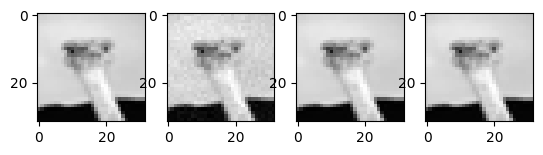

In [256]:
stored = [arr_to_img(t) for t in stored]
masked = [arr_to_img(t) for t in masked]
reconstructed_set_pt = [arr_to_img(t) for t in reconstructed_pt[0]]
reconstructed_set_tf = [arr_to_img(t) for t in reconstructed_tf]

# take a look at the original image, the masked image, and the retrieved image
idx = 2
plt.figure
plt.subplot(1,4,1)
plt.imshow(stored[idx], cmap='grey')
plt.title("Original image")
plt.subplot(1,4,2)
plt.imshow(masked[idx], cmap='grey')
plt.title("Noisy image")
plt.subplot(1,4,3)
plt.imshow(reconstructed_set_tf[idx], cmap='grey')
plt.title("Our implementation")
plt.subplot(1,4,4)
plt.imshow(reconstructed_set_pt[idx], cmap='grey')
plt.title("Original implementation")


We will now run testing on our reconstructed images and compare them against our original test. We will first use MSE to calculate the noise level of original images and noisy images. Then, we will use a CLIP model to vectorize the reconstructed images and use COSINE similarity to compare these vectors and return a similarity score.

In [ ]:
from sentence_transformers import SentenceTransformer, util

def calculate_average_mse(original_images, altered_images):
    """
    Calculate the average Mean Squared Error (MSE) between corresponding original and altered images.

    Parameters:
    original_images (list of numpy arrays): List of original 32x32 images
    altered_images (list of numpy arrays): List of altered 32x32 images (same length as original_images)

    Returns:
    float: Average MSE across all image pairs
    """
    if len(original_images) != len(altered_images):
        raise ValueError("The number of original and altered images must be the same.")

    total_mse = 0.0
    num_images = len(original_images)

    for orig_img, alt_img in zip(original_images, altered_images):

        # orig_img = np.array(orig_img)
        # alt_img = np.array(alt_img)

        if orig_img.shape != alt_img.shape:
            raise ValueError("All image pairs must be the same size!")

        # Calculate MSE for this image pair
        mse = np.mean((orig_img - alt_img) ** 2)
        total_mse += mse

    average_mse = total_mse / num_images
    return average_mse


def calculate_vector_similarity(original_images, altered_images):
    """
    Calculate vectorized similarity between original and altered images using a pre-trained CLIP model. There
    is an assumption that the lists are corresponding (original_images[i] corresponds to altered_images[i])

    Parameters:
    original_images (list of numpy arrays): List of original 32x32 images
    altered_images (list of numpy arrays): List of altered 32x32 images (same length as original_images)

    Returns:
    list: accuracy for images pairs
    """

    model = SentenceTransformer("clip-ViT-B-32")

    scores = []

    for orig_img, alt_img in zip(original_images, altered_images):

        orig_img = tf.expand_dims(orig_img, axis=1)
        orig_img = tf.expand_dims(orig_img, axis=1)

        alt_img = tf.expand_dims(alt_img, axis=1)
        alt_img = tf.expand_dims(alt_img, axis=1)

        orig_img_pil = tf.keras.preprocessing.image.array_to_img(orig_img)
        alt_img_pil = tf.keras.preprocessing.image.array_to_img(alt_img)

        joined_image_list = [orig_img_pil, alt_img_pil]
        encoded_image = model.encode(
            joined_image_list,
            batch_size=2,
            convert_to_tensor=True,
            show_progress_bar=False,
        )

        processed_images = util.paraphrase_mining_embeddings(encoded_image)

        for score, image_id1, image_id2 in processed_images:
            scores.append(score)
    return scores

# Reference / Public Implementation Links
1. (the original paper github repo) https://github.com/ml-jku/hopfield-layers
2. (the blog) https://ml-jku.github.io/hopfield-layers/
3. (the original paper) https://arxiv.org/abs/2008.02217
4. (base_1 reference notebook) https://github.com/ml-jku/hopfield-layers/blob/gh-pages/examples/simpsons/continuous_hopfield_pytorch.ipynb
